In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models  # torchvision package contains many types of datasets (including MNIST dataset) and pre-trained models
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt

import os
import random
import time
from datetime import timedelta, datetime
from PIL import Image
import cv2  # for video
from google.colab import files, drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# kaggle API
# !pip install -q kaggle
# upload kaggle.json
# files.upload()

# create a kaggle folder
# ! mkdir ~/.kaggle
# copy the kaggle.json to folder created
# ! cp kaggle.json ~/.kaggle/
# permission for the json to act
# ! chmod 600 ~/.kaggle/kaggle.json

# to list all datasets in kaggle
# ! kaggle datasets list
# Van Gogh Paintings
# ! unzip .zip

******************************************************************************

Supporting_Functions

******************************************************************************



In [3]:
# this class includes some general supporting functions for CNN Transfer Learning
class Supporting_Functions:
    def __init__(self, log_filename, content_image_path, style_image_path, device, content_weight, style_weight, learning_rate, steps, storage_limit):
        super().__init__()
        self.log_filename = log_filename
        self.content_image_path = content_image_path
        self.style_image_path = style_image_path
        self.device = device
        self.content_weight = content_weight
        self.style_weight = style_weight
        self.learning_rate = learning_rate
        self.steps = steps
        self.storage_limit = storage_limit

    def enter_log(self, text, header=False):
        file = open(self.log_filename, "a")

        if header:
            log_str = str(datetime.now().strftime("%d/%m/%Y %H:%M:%S")) + "\nContent Image: " + self.content_image_path + "\nStyle Image: " + self.style_image_path \
                      + "\ndevice: " + str(self.device) + ", content_weight: " + str(self.content_weight) + ", style_weight: " + str(self.style_weight) + ", learning_rate: " \
                      + str(self.learning_rate) + ", steps: " + str(self.steps) + ", storage_limit: " + str(self.storage_limit)
            file.write("\n\n" + log_str + "\n\n")

        file.write(text + "\n")
        file.close()

    # 1st dimension: color, 2nd dimension: width, 3rd dimension: height of image and pixels
    def image_convert_to_numpy(self, tensor):
        image = tensor.clone().detach().cpu().numpy()  # clones to tensor and transforms to numpy array. OR tensor.cpu().clone().detach().numpy()
        image = image.squeeze()
        image = image.transpose(1, 2, 0)
        # print(image.shape)                                                                            # (28, 28, 1)
        # denormalize image
        image = image * np.array((0.5,)) + np.array((0.5,))
        image = image.clip(0, 1)
        return image

    def load_image(self, path, max_size=600, shape=None):
        image = Image.open(path).convert('RGB')
        size = max(image.size)

        if size > max_size:
            size = max_size

        if shape is not None:
            size = shape

        # transform image to be compatible with the model
        transform = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))])

        image = transform(image).unsqueeze(0)  # to add extra dimensionality
        return image

    def create_video(self, images):
      frame_per_sec = 30
      frame_height, frame_width, _ = images[0].shape
      video = cv2.VideoWriter('transformation_video.avi', cv2.VideoWriter_fourcc(*'DIVX'), frame_per_sec, (frame_width, frame_height))

      for i in range(len(images)):
        cur_image = images[i]
        # make current image RGB
        cur_image = cur_image * 255
        cur_image = np.array(cur_image, dtype=np.uint8)
        cur_image = cv2.cvtColor(cur_image, cv2.COLOR_BGR2RGB)
        video.write(cur_image)

      video.release()
      # video is fully written and ready to be saved
      # cv2.destroyAllWindows()
      SF.enter_log('Video created.')

    def plot_images(self, images, nrows=1):
      names = ['Content Image', 'Style Image', 'Target Image']
      fig, axeslist = plt.subplots(ncols=int(len(images)/nrows), nrows=nrows)
      for i in range(len(images)):
        axeslist.ravel()[i].imshow(SF.image_convert_to_numpy(images[i]))
        axeslist.ravel()[i].set_title(names[i])
        axeslist.ravel()[i].set_axis_off()
      plt.tight_layout()
      if len(images) > 2:
        plt.savefig('three_images.jpg', dpi=500, bbox_inches='tight')
      plt.show()

    def save_image(self, image, name):
      # save_image(image, fp=name, normalize=True)
      plt.imshow(SF.image_convert_to_numpy(image))
      plt.axis('off')
      plt.savefig(name, dpi=500, bbox_inches='tight')
      # plt.show()

    def select_image_from_dataset(self, dir_artists, dir_van_gogh):
      choice = input("Van Gogh(V) or All Artists(A):")
      if choice == 'V':
        for i, filename in enumerate(os.listdir(dir_van_gogh)):
          print(filename)
        artist = input("Select type:")
        source_folder = os.path.join(dir_van_gogh, artist)
        image = random.choice(os.listdir(source_folder))        
        while not image.endswith(".jpg"):
          image = random.choice(os.listdir(source_folder))
        print('selected image name:', image)
        return os.path.join(source_folder, image)
      else:
        for i, filename in enumerate(os.listdir(dir_artists)):
          print(filename)
        artist = input("Select artist:")
        source_folder = os.path.join(dir_artists, artist)
        image = random.choice(os.listdir(source_folder))        
        while not image.endswith(".jpg"):
          image = random.choice(os.listdir(source_folder))
        print('selected image name:', image)
        return os.path.join(source_folder, image)
      
      


******************************************************************************

Training Algorithm

******************************************************************************


In [4]:
# HYPERPARAMETERS
# style content ratio: alpha represents content image weight and beta represents style image weight
content_weight = 1
style_weight = 1e6      # (1e1, 1e6)

# learning rate
learning_rate = 0.004

# steps, iterations
steps = 2100
additional_steps = 100

# assign weight to each style layer for representation power (early layers have more style)
style_weights = {'conv1_1': 1.,
                 'conv2_1': .78,
                 'conv3_1': .25,
                 'conv4_1': .22,
                 'conv5_1': .18}

# dictionary that holds the specific layer numbers where features will be extracted. You can play with them.
# Conv1_1, Conv2_1, Conv3_1, Conv4_1, Conv4_2, Conv5_1
layers = {'0': 'conv1_1',    # style extraction
          '5': 'conv2_1',    # style extraction
          '10': 'conv3_1',   # style extraction
          '19': 'conv4_1',   # style extraction
          '21': 'conv4_2',   # content extraction
          '28': 'conv5_1'}   # style extraction

content_layer = 'conv4_2'


# AUXILARY PARAMETERS
# step number
storage_limit = 300

# print variables
print_per = 10
show_per = 50


# datasets
dataset_directory_artists = '/content/drive/MyDrive/CS-464 Project/CNN_files/Artists'
dataset_directory_van_gogh = '/content/drive/MyDrive/CS-464 Project/CNN_files/Van_Gogh'

content_image_path = '/content/drive/MyDrive/CS-464 Project/CNN_files/HayleyWilliams.jpg'
# style_image_path = '/content/drive/MyDrive/CS-464 Project/CNN_files/AngelOfLove.jpeg'
log_filename = "/content/drive/MyDrive/CS-464 Project/CNN_files/log_CNN_Style_Transfer.txt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   # specifies run device for more optimum runtime

########################################################################################################################

# returns pre-trained VGG19 model
def get_model():
    # VGG 19 pre-trained model
    model = models.vgg19(pretrained=True).features
    SF.enter_log('VGG 19 pre-trained model is created.')

    # freeze parameters
    for param in model.parameters():
        param.requires_grad = False

    # send model to GPU
    model.to(device=device)
    return model


# extracts the features from image using model
def get_features(image, model):
    # dict that will store the extracted features
    features = {}
    # iterate through all layers and store the on es in the layers dict
    for name, layer in model._modules.items():
        # run image through all layers
        image = layer(image)
        if name in layers:
            features[layers[name]] = image
    return features


# Gram Matrix = V(T)*V  T: Transpose
def gram_matrix(tensor):
    # takes 4D image tensor
    # reshape the tensor
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h*w)
    gram = torch.mm(tensor, tensor.t())
    return gram


def train(model, content_image, style_image, steps):
    # get content and style features
    content_features = get_features(content_image, model)
    style_features = get_features(style_image, model)

    # style features need one more step to be more useful (Gram Matrix)
    # applying Gram Matrix eliminates the remaining content information from style features
    # Gram Matrix = V(T)*V  T: Transpose
    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

    # define target image
    target_image = content_image.clone().requires_grad_(True).to(device=device)

    # training process images
    height, width, channels = SF.image_convert_to_numpy(target_image).shape
    images = np.empty(shape=(storage_limit, height, width, channels))

    # Adam Optimizer
    optimizer = torch.optim.Adam([target_image], lr=learning_rate)

    # training process
    SF.enter_log('Training begins...')
    iter = 0
    start_training_time = time.time()
    for ii in range(1, steps + 1):
        target_features = get_features(target_image, model)
        # calculate the content loss between content and target images using Mean Squared Error
        content_loss = torch.mean((target_features[content_layer] - content_features[content_layer]) ** 2)

        # calculate style loss iterating through 5 style layers
        style_loss = 0
        for style_layer in style_weights:
            # calculate target gram for cur layer
            target_feature = target_features[style_layer]
            target_gram = gram_matrix(target_feature)
            # get corresponding style gram from the precalculated list
            style_gram = style_grams[style_layer]
            current_style_loss = style_weights[style_layer] * torch.mean((target_gram - style_gram) ** 2)
            # normalize current_style_loss
            _, d, h, w = target_feature.shape
            style_loss += current_style_loss / (d * h * w)

        # optimizer will be used to optimize the parameters of the target image according to content and style losses
        # Style Aim: is to match the target gram matrix to the style gram matrix
        # Content Aim: is to match the target features (filtered image) to the content features
        total_loss = content_weight * content_loss + style_weight * style_loss

        optimizer.zero_grad()  # reset optimizer
        total_loss.backward()
        optimizer.step()

        # data visualization throughout the training process
        # print period
        if ii % print_per == 0:
            finish_training_time = time.time()
            print_str = 'iteration: ' + str(ii) + ' loss: ' + str(total_loss.item()) + ' time passed: ' + str(timedelta(seconds=finish_training_time - start_training_time))
            print(print_str)
            SF.enter_log(print_str)

        # show image period
        if ii % show_per == 0:
            plt.imshow(SF.image_convert_to_numpy(target_image))
            plt.axis('off')
            plt.show()

        # store mid images period
        if ii % (steps / storage_limit) == 0:
            images[iter] = SF.image_convert_to_numpy(target_image)
            iter += 1

    SF.enter_log('Training completed.')
    return target_image, images



******************************************************************************

Main Function

******************************************************************************

Van Gogh(V) or All Artists(A):V
Works of the young van Gogh
Nuenen
Auvers sur Oise
Arles
Sketches in letters
Villege
Drawings
Face
Saint Remy
Watercolors
Paris
Select type:Saint Remy
selected image name: Cottages and Cypresses Reminiscence of the North.jpg


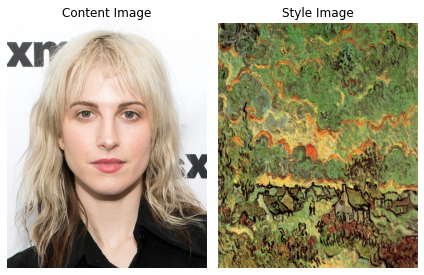

iteration: 10 loss: 65885032.0 time passed: 0:00:04.134136
iteration: 20 loss: 37567444.0 time passed: 0:00:09.124229
iteration: 30 loss: 23063054.0 time passed: 0:00:16.543892
iteration: 40 loss: 15637590.0 time passed: 0:00:20.922900
iteration: 50 loss: 11300154.0 time passed: 0:00:28.877479


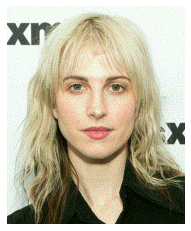

iteration: 60 loss: 8599083.0 time passed: 0:00:33.178456
iteration: 70 loss: 6848905.0 time passed: 0:00:38.739878
iteration: 80 loss: 5680498.5 time passed: 0:00:45.545752
iteration: 90 loss: 4870507.5 time passed: 0:00:50.510795
iteration: 100 loss: 4285476.0 time passed: 0:00:57.887661


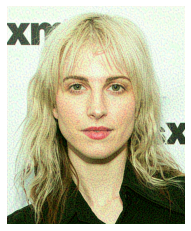

iteration: 110 loss: 3845888.75 time passed: 0:01:02.483461
iteration: 120 loss: 3502828.75 time passed: 0:01:10.433618
iteration: 130 loss: 3226139.25 time passed: 0:01:14.566651
iteration: 140 loss: 2996820.5 time passed: 0:01:20.103029
iteration: 150 loss: 2802728.25 time passed: 0:01:26.918382


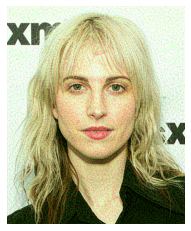

iteration: 160 loss: 2635796.75 time passed: 0:01:32.044196
iteration: 170 loss: 2490331.5 time passed: 0:01:39.412660
iteration: 180 loss: 2362260.75 time passed: 0:01:43.783466
iteration: 190 loss: 2248586.5 time passed: 0:01:51.725568
iteration: 200 loss: 2147057.25 time passed: 0:01:55.852959


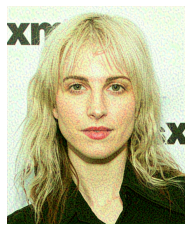

iteration: 210 loss: 2055925.375 time passed: 0:02:01.545008
iteration: 220 loss: 1973759.125 time passed: 0:02:08.289097
iteration: 230 loss: 1899417.75 time passed: 0:02:13.215233
iteration: 240 loss: 1831933.375 time passed: 0:02:20.537780
iteration: 250 loss: 1770479.375 time passed: 0:02:24.886863


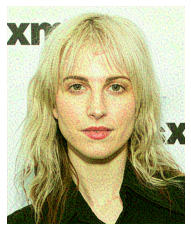

iteration: 260 loss: 1714383.25 time passed: 0:02:32.943116
iteration: 270 loss: 1663050.625 time passed: 0:02:37.042010
iteration: 280 loss: 1615964.125 time passed: 0:02:42.537990
iteration: 290 loss: 1572668.5 time passed: 0:02:49.245447
iteration: 300 loss: 1532735.875 time passed: 0:02:54.124777


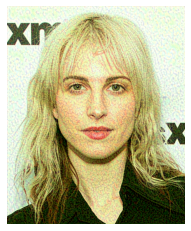

iteration: 310 loss: 1495826.125 time passed: 0:03:01.532106
iteration: 320 loss: 1461627.375 time passed: 0:03:05.840109
iteration: 330 loss: 1429864.125 time passed: 0:03:13.667354
iteration: 340 loss: 1400282.875 time passed: 0:03:17.736534
iteration: 350 loss: 1372660.375 time passed: 0:03:23.209954


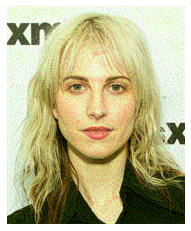

iteration: 360 loss: 1346788.375 time passed: 0:03:30.035063
iteration: 370 loss: 1322479.625 time passed: 0:03:34.909437
iteration: 380 loss: 1299574.375 time passed: 0:03:42.183784
iteration: 390 loss: 1277926.375 time passed: 0:03:46.497438
iteration: 400 loss: 1257407.625 time passed: 0:03:54.318158


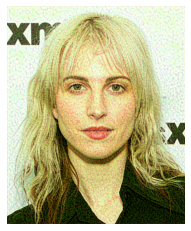

iteration: 410 loss: 1237910.875 time passed: 0:03:58.538239
iteration: 420 loss: 1219338.75 time passed: 0:04:03.992410
iteration: 430 loss: 1201605.5 time passed: 0:04:10.681470
iteration: 440 loss: 1184632.125 time passed: 0:04:15.546816
iteration: 450 loss: 1168347.25 time passed: 0:04:22.807606


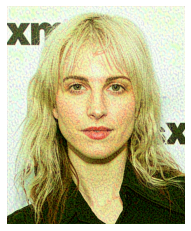

iteration: 460 loss: 1152694.75 time passed: 0:04:27.267662
iteration: 470 loss: 1137622.375 time passed: 0:04:35.068533
iteration: 480 loss: 1123079.25 time passed: 0:04:39.139215
iteration: 490 loss: 1109023.0 time passed: 0:04:44.571470
iteration: 500 loss: 1095420.375 time passed: 0:04:51.253459


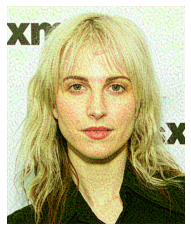

iteration: 510 loss: 1082236.25 time passed: 0:04:56.286247
iteration: 520 loss: 1069442.375 time passed: 0:05:03.521329
iteration: 530 loss: 1057010.0 time passed: 0:05:07.831350
iteration: 540 loss: 1044919.0 time passed: 0:05:15.651003
iteration: 550 loss: 1033143.5 time passed: 0:05:19.708756


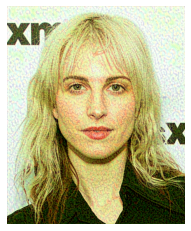

iteration: 560 loss: 1021668.125 time passed: 0:05:25.388707
iteration: 570 loss: 1010474.6875 time passed: 0:05:32.080355
iteration: 580 loss: 999548.25 time passed: 0:05:36.937037
iteration: 590 loss: 988876.5 time passed: 0:05:44.178339
iteration: 600 loss: 978450.125 time passed: 0:05:48.489608


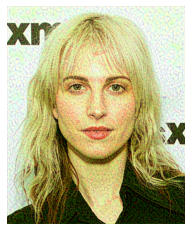

iteration: 610 loss: 968259.875 time passed: 0:05:56.452120
iteration: 620 loss: 958292.3125 time passed: 0:06:00.526649
iteration: 630 loss: 948540.375 time passed: 0:06:05.985031
iteration: 640 loss: 938994.5625 time passed: 0:06:12.664026
iteration: 650 loss: 929650.0 time passed: 0:06:17.553216


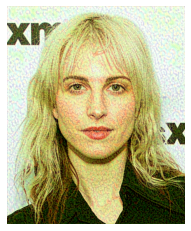

iteration: 660 loss: 920498.9375 time passed: 0:06:24.948699
iteration: 670 loss: 911534.125 time passed: 0:06:29.258628
iteration: 680 loss: 902748.375 time passed: 0:06:37.106400
iteration: 690 loss: 894138.125 time passed: 0:06:41.177201
iteration: 700 loss: 885695.8125 time passed: 0:06:46.611665


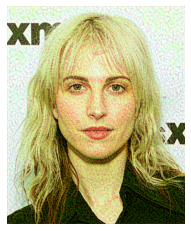

iteration: 710 loss: 877416.4375 time passed: 0:06:53.528895
iteration: 720 loss: 869294.9375 time passed: 0:06:58.478188
iteration: 730 loss: 861325.8125 time passed: 0:07:05.788636
iteration: 740 loss: 853503.75 time passed: 0:07:10.151066
iteration: 750 loss: 845827.6875 time passed: 0:07:18.065033


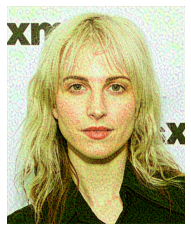

iteration: 760 loss: 838291.0 time passed: 0:07:22.352915
iteration: 780 loss: 823615.8125 time passed: 0:07:34.666000
iteration: 790 loss: 816468.4375 time passed: 0:07:39.618285
iteration: 800 loss: 809442.8125 time passed: 0:07:46.966558


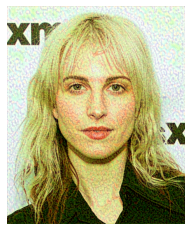

iteration: 810 loss: 802533.75 time passed: 0:07:51.496077
iteration: 820 loss: 795739.1875 time passed: 0:07:59.449222
iteration: 830 loss: 789057.3125 time passed: 0:08:03.584548
iteration: 840 loss: 782485.0 time passed: 0:08:09.125804
iteration: 850 loss: 776015.375 time passed: 0:08:15.916825


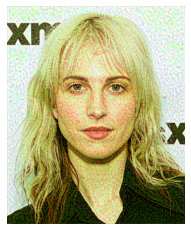

iteration: 860 loss: 769644.625 time passed: 0:08:21.038752
iteration: 870 loss: 763371.3125 time passed: 0:08:28.405598
iteration: 880 loss: 757190.9375 time passed: 0:08:32.798533
iteration: 890 loss: 751101.75 time passed: 0:08:40.779278
iteration: 900 loss: 745100.3125 time passed: 0:08:44.904024


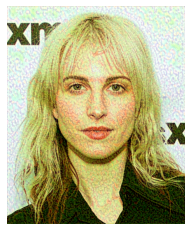

iteration: 910 loss: 739185.125 time passed: 0:08:50.603680
iteration: 920 loss: 733355.125 time passed: 0:08:57.407444
iteration: 930 loss: 727605.875 time passed: 0:09:02.374503
iteration: 940 loss: 721934.625 time passed: 0:09:09.734843
iteration: 950 loss: 716339.75 time passed: 0:09:14.110750


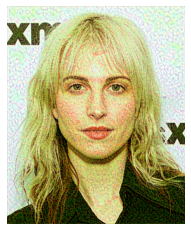

iteration: 960 loss: 710819.4375 time passed: 0:09:22.202928
iteration: 970 loss: 705370.8125 time passed: 0:09:26.326915
iteration: 980 loss: 699992.25 time passed: 0:09:31.859636
iteration: 990 loss: 694681.1875 time passed: 0:09:38.644265
iteration: 1000 loss: 689435.0 time passed: 0:09:43.579473


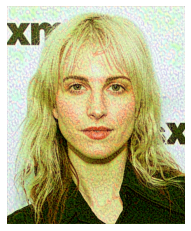

iteration: 1010 loss: 684252.4375 time passed: 0:09:51.083477
iteration: 1020 loss: 679131.6875 time passed: 0:09:55.440500
iteration: 1030 loss: 674071.4375 time passed: 0:10:03.390997
iteration: 1040 loss: 669071.0 time passed: 0:10:07.518804
iteration: 1050 loss: 664128.25 time passed: 0:10:13.058511


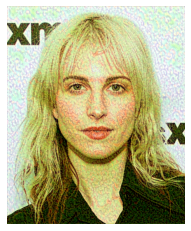

iteration: 1060 loss: 659242.6875 time passed: 0:10:19.984946
iteration: 1070 loss: 654412.8125 time passed: 0:10:24.935930
iteration: 1080 loss: 649636.875 time passed: 0:10:32.294593
iteration: 1090 loss: 644912.625 time passed: 0:10:36.676958
iteration: 1100 loss: 640240.5625 time passed: 0:10:44.632764


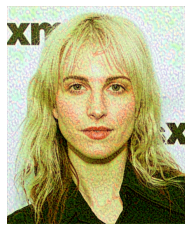

iteration: 1110 loss: 635619.9375 time passed: 0:10:48.924602
iteration: 1120 loss: 631049.0 time passed: 0:10:54.444989
iteration: 1130 loss: 626527.1875 time passed: 0:11:01.243251
iteration: 1140 loss: 622053.1875 time passed: 0:11:06.198372
iteration: 1150 loss: 617625.9375 time passed: 0:11:13.574868


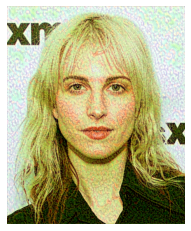

iteration: 1160 loss: 613243.25 time passed: 0:11:18.103833
iteration: 1170 loss: 608904.5625 time passed: 0:11:26.067132
iteration: 1180 loss: 604608.5625 time passed: 0:11:30.210708
iteration: 1190 loss: 600356.0 time passed: 0:11:35.759610
iteration: 1200 loss: 596145.0 time passed: 0:11:42.547400


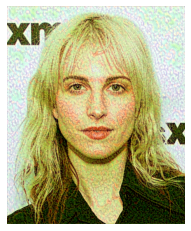

iteration: 1210 loss: 591975.625 time passed: 0:11:47.654808
iteration: 1220 loss: 587846.1875 time passed: 0:11:55.025367
iteration: 1230 loss: 583756.8125 time passed: 0:11:59.399863
iteration: 1240 loss: 579706.625 time passed: 0:12:07.349546
iteration: 1250 loss: 575694.75 time passed: 0:12:11.475542


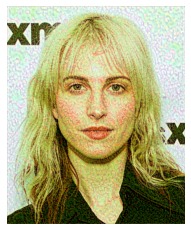

iteration: 1260 loss: 571720.25 time passed: 0:12:17.154200
iteration: 1270 loss: 567783.3125 time passed: 0:12:23.962951
iteration: 1280 loss: 563882.8125 time passed: 0:12:28.908686
iteration: 1290 loss: 560017.3125 time passed: 0:12:36.263077
iteration: 1300 loss: 556186.125 time passed: 0:12:40.651545


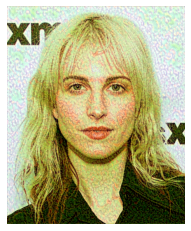

iteration: 1310 loss: 552388.75 time passed: 0:12:48.743063
iteration: 1320 loss: 548625.0625 time passed: 0:12:52.867091
iteration: 1330 loss: 544894.5 time passed: 0:12:58.403632
iteration: 1340 loss: 541196.25 time passed: 0:13:05.204955
iteration: 1350 loss: 537530.125 time passed: 0:13:10.170605


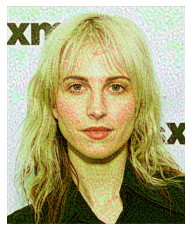

iteration: 1360 loss: 533896.1875 time passed: 0:13:17.711371
iteration: 1370 loss: 530293.8125 time passed: 0:13:22.075888
iteration: 1380 loss: 526722.8125 time passed: 0:13:30.028210
iteration: 1390 loss: 523181.78125 time passed: 0:13:34.168064
iteration: 1400 loss: 519669.9375 time passed: 0:13:39.690132


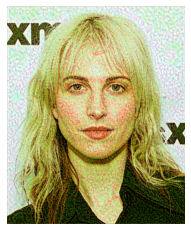

iteration: 1410 loss: 516186.40625 time passed: 0:13:46.650758
iteration: 1420 loss: 512730.84375 time passed: 0:13:51.632406
iteration: 1430 loss: 509303.65625 time passed: 0:13:59.002158
iteration: 1440 loss: 505903.5625 time passed: 0:14:03.376987
iteration: 1450 loss: 502531.4375 time passed: 0:14:11.350453


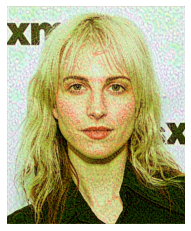

iteration: 1460 loss: 499187.71875 time passed: 0:14:15.737120
iteration: 1470 loss: 495871.09375 time passed: 0:14:21.267051
iteration: 1480 loss: 492582.21875 time passed: 0:14:28.041824
iteration: 1490 loss: 489319.875 time passed: 0:14:32.987335
iteration: 1500 loss: 486083.875 time passed: 0:14:40.350112


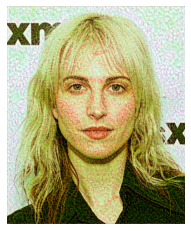

iteration: 1510 loss: 482873.28125 time passed: 0:14:44.871801
iteration: 1520 loss: 479688.46875 time passed: 0:14:52.820668
iteration: 1530 loss: 476528.1875 time passed: 0:14:56.955793
iteration: 1540 loss: 473392.5 time passed: 0:15:02.478905
iteration: 1550 loss: 470281.5625 time passed: 0:15:09.277930


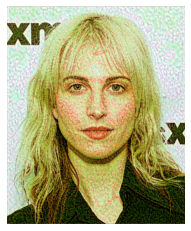

iteration: 1560 loss: 467194.03125 time passed: 0:15:14.380548
iteration: 1570 loss: 464130.09375 time passed: 0:15:21.748872
iteration: 1580 loss: 461088.59375 time passed: 0:15:26.124635
iteration: 1590 loss: 458071.0 time passed: 0:15:34.084153
iteration: 1600 loss: 455076.125 time passed: 0:15:38.219662


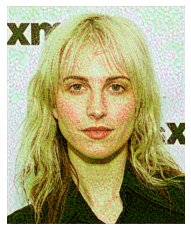

iteration: 1610 loss: 452102.96875 time passed: 0:15:43.927244
iteration: 1620 loss: 449152.75 time passed: 0:15:50.729892
iteration: 1630 loss: 446225.4375 time passed: 0:15:55.702615
iteration: 1640 loss: 443319.6875 time passed: 0:16:03.061081
iteration: 1650 loss: 440435.21875 time passed: 0:16:07.434360


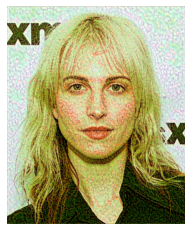

iteration: 1660 loss: 437571.8125 time passed: 0:16:15.554887
iteration: 1670 loss: 434728.875 time passed: 0:16:19.678262
iteration: 1680 loss: 431906.75 time passed: 0:16:25.221708
iteration: 1690 loss: 429105.90625 time passed: 0:16:32.002274
iteration: 1700 loss: 426325.21875 time passed: 0:16:36.968221


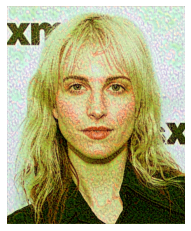

iteration: 1710 loss: 423564.84375 time passed: 0:16:44.498706
iteration: 1720 loss: 420824.96875 time passed: 0:16:48.864563
iteration: 1730 loss: 418103.875 time passed: 0:16:56.805954
iteration: 1740 loss: 415401.375 time passed: 0:17:00.948230
iteration: 1750 loss: 412717.28125 time passed: 0:17:06.482239


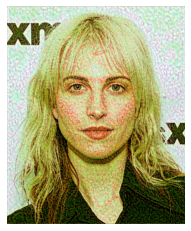

iteration: 1760 loss: 410052.28125 time passed: 0:17:13.416236
iteration: 1770 loss: 407406.5 time passed: 0:17:18.367141
iteration: 1780 loss: 404778.90625 time passed: 0:17:25.738036
iteration: 1790 loss: 402169.5 time passed: 0:17:30.141694
iteration: 1800 loss: 399577.5625 time passed: 0:17:38.114775


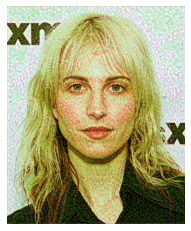

iteration: 1810 loss: 397003.25 time passed: 0:17:42.388122
iteration: 1820 loss: 394447.375 time passed: 0:17:47.901292
iteration: 1830 loss: 391909.0 time passed: 0:17:54.692037
iteration: 1840 loss: 389388.21875 time passed: 0:17:59.666125
iteration: 1850 loss: 386883.875 time passed: 0:18:07.036233


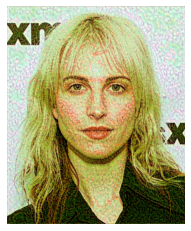

iteration: 1860 loss: 384396.3125 time passed: 0:18:11.586092
iteration: 1870 loss: 381924.84375 time passed: 0:18:19.545931
iteration: 1880 loss: 379470.28125 time passed: 0:18:23.671437
iteration: 1890 loss: 377032.59375 time passed: 0:18:29.219516
iteration: 1900 loss: 374611.53125 time passed: 0:18:36.025201


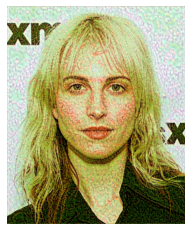

iteration: 1910 loss: 372207.03125 time passed: 0:18:41.150895
iteration: 1920 loss: 369818.0625 time passed: 0:18:48.556721
iteration: 1930 loss: 367445.3125 time passed: 0:18:52.937049
iteration: 1940 loss: 365087.4375 time passed: 0:19:00.894099
iteration: 1950 loss: 362744.6875 time passed: 0:19:05.035948


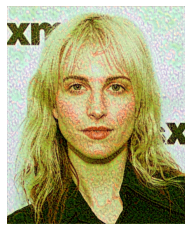

iteration: 1960 loss: 360416.96875 time passed: 0:19:10.713571
iteration: 1970 loss: 358104.34375 time passed: 0:19:17.516680
iteration: 1980 loss: 355806.71875 time passed: 0:19:22.480694
iteration: 1990 loss: 353523.6875 time passed: 0:19:29.863250
iteration: 2000 loss: 351255.0625 time passed: 0:19:34.281677


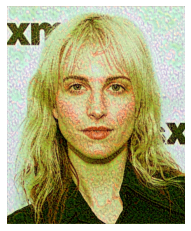

iteration: 2010 loss: 349000.84375 time passed: 0:19:42.377149
iteration: 2020 loss: 346760.59375 time passed: 0:19:46.519552
iteration: 2030 loss: 344535.0625 time passed: 0:19:52.062120
iteration: 2040 loss: 342323.4375 time passed: 0:19:58.860352
iteration: 2050 loss: 340125.625 time passed: 0:20:03.824799


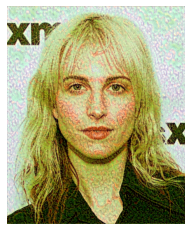

iteration: 2060 loss: 337941.21875 time passed: 0:20:11.352674
iteration: 2070 loss: 335769.6875 time passed: 0:20:15.726653
iteration: 2080 loss: 333611.9375 time passed: 0:20:23.704101
iteration: 2090 loss: 331467.1875 time passed: 0:20:27.818515
iteration: 2100 loss: 329336.0 time passed: 0:20:33.354574


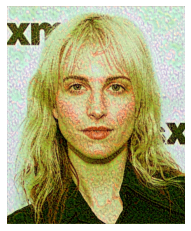

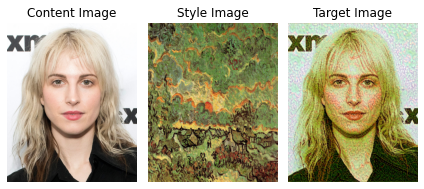

In [5]:
SF = Supporting_Functions(log_filename, content_image_path, '/from dataset', device, content_weight, style_weight, learning_rate, steps, storage_limit)

# get content and style images
content_image = SF.load_image(content_image_path).to(device=device)
style_image_path = SF.select_image_from_dataset(dataset_directory_artists, dataset_directory_van_gogh)
style_image = SF.load_image(style_image_path, shape=content_image.shape[-2:]).to(device=device)
SF.enter_log('Content and Style images are retrieved.', header=True)

# get VGG19 pre-trained model
model = get_model()

# plot content and style images
SF.plot_images([content_image, style_image])

# train target image
target_image, images = train(model, content_image, style_image, steps)

# plot content, style, and target images
SF.plot_images([content_image, style_image, target_image])

******************************************************************************

Second Main Function

******************************************************************************

In [6]:
def train2(model, content_image, style_image, steps_, target_image):
    # get content and style features
    content_features = get_features(content_image, model)
    style_features = get_features(style_image, model)

    # style features need one more step to be more useful (Gram Matrix)
    # applying Gram Matrix eliminates the remaining content information from style features
    # Gram Matrix = V(T)*V  T: Transpose
    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}


    # training process images
    height, width, channels = SF.image_convert_to_numpy(target_image).shape
    images = np.empty(shape=(storage_limit, height, width, channels))

    # Adam Optimizer
    optimizer = torch.optim.Adam([target_image], lr=learning_rate)

    # training process
    iter = 0
    start_training_time = time.time()
    for ii in range(1, steps_ + 1):
        target_features = get_features(target_image, model)
        # calculate the content loss between content and target images using Mean Squared Error
        content_loss = torch.mean((target_features[content_layer] - content_features[content_layer]) ** 2)

        # calculate style loss iterating through 5 style layers
        style_loss = 0
        for style_layer in style_weights:
            # calculate target gram for cur layer
            target_feature = target_features[style_layer]
            target_gram = gram_matrix(target_feature)
            # get corresponding style gram from the precalculated list
            style_gram = style_grams[style_layer]
            current_style_loss = style_weights[style_layer] * torch.mean((target_gram - style_gram) ** 2)
            # normalize current_style_loss
            _, d, h, w = target_feature.shape
            style_loss += current_style_loss / (d * h * w)

        # optimizer will be used to optimize the parameters of the target image according to content and style losses
        # Style Aim: is to match the target gram matrix to the style gram matrix
        # Content Aim: is to match the target features (filtered image) to the content features
        total_loss = content_weight * content_loss + style_weight * style_loss

        optimizer.zero_grad()  # reset optimizer
        total_loss.backward()
        optimizer.step()

        # data visualization throughout the training process
        # print period
        if ii % print_per == 0:
            finish_training_time = time.time()
            print_str = 'iteration: ' + str(ii + steps) + ' loss: ' + str(total_loss.item() / (height * width)) + ' time passed: ' + str(timedelta(seconds=finish_training_time - start_training_time))
            print(print_str)
            SF.enter_log(print_str)

        # show image period
        if ii % show_per == 0:
            plt.imshow(SF.image_convert_to_numpy(target_image))
            plt.axis('off')
            plt.show()

    SF.enter_log('Training completed.')
    return target_image


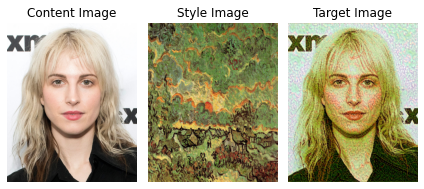

iteration: 2110 loss: 0.7713511196145125 time passed: 0:00:03.185281
iteration: 2120 loss: 0.7506845946712019 time passed: 0:00:09.031405
iteration: 2130 loss: 0.7244566326530613 time passed: 0:00:14.860198
iteration: 2140 loss: 0.7145301162131519 time passed: 0:00:20.699414
iteration: 2150 loss: 0.7045839002267573 time passed: 0:00:26.545273


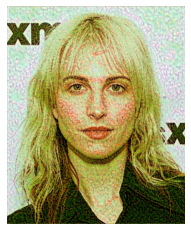

iteration: 2160 loss: 0.6963027210884354 time passed: 0:00:32.625239
iteration: 2170 loss: 0.6882962018140589 time passed: 0:00:38.471671
iteration: 2180 loss: 0.6802732426303855 time passed: 0:00:44.317021
iteration: 2190 loss: 0.6722157029478458 time passed: 0:00:50.165454
iteration: 2200 loss: 0.6640381944444445 time passed: 0:00:56.006917


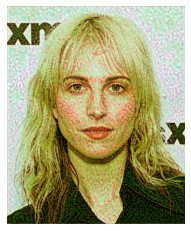

In [7]:
# plot content and style images
SF.plot_images([content_image, style_image, target_image])

# train target image
target_image = train2(model, content_image, style_image, additional_steps, target_image)

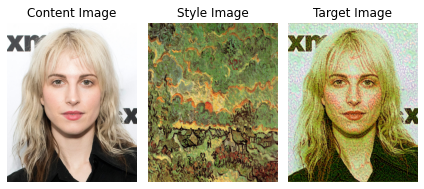

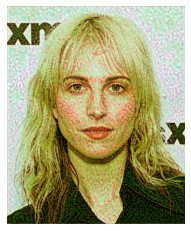

In [8]:
# plot content, style, and target images
SF.plot_images([content_image, style_image, target_image])

# save target image
SF.save_image(target_image, 'target_image.jpg')

# create video
SF.create_video(images)